In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import scipy

import os
import glob
import sys

%matplotlib inline

# Batch Management

In [4]:
class RoverImageIterator:
    
    def __init__(self, num_rover_images, img_dir, msk_dir):
        self.num_rover_images = num_rover_images
        self.img_dir = img_dir
        self.msk_dir = msk_dir
        
        self.iterator = 0
        self.img_pairs = []
        
    
    # creates a list of file name / mask name pairs and shuffles them.
    # these will be used to create the batches during training.
    def setup_rover_iterator(self):
        
        # reset the iterator
        self.iterator = 0
        self.img_pairs = []
        
        for i in range(self.num_rover_images):
            img_std_file = self.img_dir + "img_" + str(i) + ".jpg"
            img_flp_file = self.img_dir + "img_flipped_" + str(i) + ".jpg"
            img_msk_file = self.msk_dir + "img_scaled_mask_" + str(i) + ".jpg"
            img_flp_msk_file = self.msk_dir + "img_scaled_flipped_mask_" + str(i) + ".jpg"
            
            self.img_pairs.append( (img_std_file, img_msk_file) )
            self.img_pairs.append( (img_flp_file, img_flp_msk_file) )
        
        np.random.shuffle(self.img_pairs)
        
    
    def next_batch(self, batch_size):
        batch_files = []

        if self.iterator + batch_size < len(self.img_pairs):
            batch_files = self.img_pairs[self.iterator:self.iterator+batch_size]
            self.iterator += batch_size
        else:
            diff = (self.iterator + batch_size) - len(self.img_pairs)
            
            batch_files_1 = self.img_pairs[self.iterator:len(self.img_pairs)]
            batch_files_2 = self.img_pairs[0:diff]
            
            batch_files = batch_files_1 + batch_files_2
        
        
        images = []
        masks = []
        
        for img_file, msk_file in batch_files:
            img = scipy.ndimage.imread(img_file) / 255 # normalize inputs
            msk = scipy.ndimage.imread(msk_file)
            
            images.append(img)
            masks.append(msk)
    
        return images, masks
        

In [6]:
rover_image_iterator = RoverImageIterator(10, '../data_collection/images/', '../data_collection/masks_small/')

In [8]:
rover_image_iterator.setup_rover_iterator()

In [35]:
images, masks = images, masks = rover_image_iterator.next_batch(10)

In [38]:
np_masks = np.asarray(masks).reshape((10, 120, 160, 1))

In [39]:
np_masks[0].shape

(120, 160, 1)

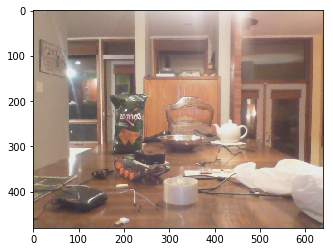

In [10]:
plt.imshow(images[0])

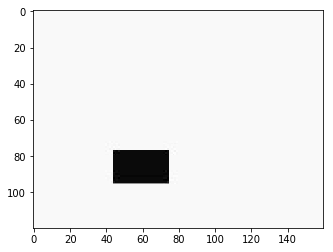

In [12]:
plt.imshow(masks[0], cmap='Greys')

# Helper Functions

In [13]:
def init_weights(shape):
    init_random_dist = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(init_random_dist)

In [14]:
def init_bias(shape):
    init_bias_vals = tf.constant(0.1, shape=shape)
    return init_bias_vals

In [15]:
def cov2d(x, W):
    # x shape [batch_size, height, width, channels]
    # W shape [ filter H, filter W, Ch In, Ch Out ]
    return tf.nn.conv2d(x, W, strides=[1,1,1,1], padding='SAME')

In [16]:
def max_pooling_2by2(x):
    # x shape [batch, height, width, channels]
    return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

In [17]:
def convolutional_layer(x, shape):
    W = init_weights(shape)
    b = init_bias([shape[3]])
    
    return tf.nn.relu(cov2d(x, W) + b)

In [18]:
# create convolutional layer followed by max pooling.  
# Kernel size is assumed to be symetric (so kernel size = 3 creates a 3x3 kernel)
# Input Tensor: [None, Image_height, Image_width, num_channels]
# Output Tensor: [None, 0.5 * Image_Height, 0.5 * Image_Width, num_filters]
def encoder_layer(x, kernel_size, num_channels, num_filters):
    layer = convolutional_layer(x, [kernel_size, kernel_size, num_channels, num_filters])
    layer_max_pool = max_pooling_2by2(layer)
    
    return layer_max_pool

# Model

This model is inspired by standard FCN models, but with a bit of a simplification.  As I am not interested,
nor have the correct training data for, pixel level image segmentation, I've decided to try an approach
that basically drops the bilinear upsampling / decoder layers.  Here I am very much interested in a heat
map of probable locations in the image where I might find my rover, not the rovers boundary.  The approach
then is to keep the encoder layers, but simply have a standard convolutional layer at the end that just outputs
the current heat map without upsampling. So I'll be taking in 640x480 images and outputing 160X120 heatmaps.

<br/>

As I am only interested in the positional state of a single object, the heat maps can be black and white versions
of the original masks, scaled down to 160x120.  This should greatly reduce the number of parameters that need be 
learned and make it easier for the network to perform the task at hand.

## Architecture

<br/>input layer - 640x480x3
<br/>conv / max pool - 320x240x32 
<br/>conv / max pool - 160x120x64
<br/>1x1 conv - 160x120x128
<br/>1x1 conv - 160x120x64
<br/>1x1 conv - 160x120x32
<br/>conv layer (no pooling) 160x120x1

In [40]:
def fcn_heatmap_model(inputs):
    encoder_layer1 = encoder_layer(x=inputs, kernel_size=3, num_channels=3, num_filters=32)
    
    encoder_layer2 = encoder_layer(x=encoder_layer1, kernel_size=3, num_channels=32, num_filters=64)
    
    one_by_one_1 = convolutional_layer(x=encoder_layer2, shape=[1, 1, 64, 128])
    one_by_one_2 = convolutional_layer(x=one_by_one_1, shape=[1, 1, 128, 64])
    one_by_one_3 = convolutional_layer(x=one_by_one_2, shape=[1, 1, 64, 32])
    
    return convolutional_layer(x=one_by_one_3, shape=[3, 3, 32, 1])
    

# Setup Tensorflow Graph

In [49]:
# constants
learning_rate = 0.002
num_iterations = 10
batch_size = 10 # not a lot of memory on my laptop and not much of a gpu

In [50]:
# placeholders
x = tf.placeholder(tf.float32, shape=[None, 480, 640, 3])
y = tf.placeholder(tf.float32, shape=[None, 120, 160, 1])

In [51]:
model = fcn_heatmap_model(x)

In [52]:
loss = tf.reduce_mean(tf.square(model - y))

In [53]:
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train = optimizer.minimize(loss)

In [54]:
init = tf.global_variables_initializer()

# Train the Model

In [ ]:
error_history = []

rover_image_iterator.setup_rover_iterator()

with tf.Session() as sess:
    sess.run(init)
    
    for iteration in range(num_iterations):
        x_batch, y_batch = rover_image_iterator.next_batch(batch_size=batch_size)
        
        y_batch = np.asarray(y_batch).reshape((batch_size, 120, 160, 1))
          
        sess.run(train, feed_dict={x: x_batch, y:y_batch})
        
        if iteration % 1 == 0:
            error = loss.eval(feed_dict={x: x_batch, y:y_batch})
            print("Iteration: ", iteration, "\t", error)
            error_history.append(error)
        
        

Iteration:  0 	 6098.66
Iteration:  1 	 6176.64
Iteration:  2 	 6128.59
Iteration:  3 	 6065.41
Iteration:  4 	 5979.47
Iteration:  5 	 5861.77
